# FX data

In [1]:
import pandas as pd
import requests
import json
import pprint
import re

In [2]:
import os
from os.path import join
from dotenv import load_dotenv

dotenv_path = join('.env')
load_dotenv(dotenv_path)
AP = os.environ.get("API_KEY")
url = "https://alpha-vantage.p.rapidapi.com/query"

querystring = {"to_symbol":"JPY",
               #"outputsize":"compact",
               "outputsize":"full",
               "datatype":"json","from_symbol":"USD","function":"FX_DAILY"}

headers = {
    'x-rapidapi-host': "alpha-vantage.p.rapidapi.com",
    'x-rapidapi-key': "{}".format(AP)
    }

response = requests.request("GET", url, headers=headers, params=querystring)

In [3]:
d  = json.loads(response.text)
d_ext = d['Time Series FX (Daily)']
s_ext = json.dumps(d_ext)
df= pd.read_json(s_ext).T.sort_index().reset_index()
df.columns=['Date','Open','High','Low','Close']
df.set_index('Date', inplace=True)
df['Volume']=1

In [4]:
df.tail(5)

,Open,High,Low,Close,Volume
Date,,,,,
2020-12-29,103.779,103.830,103.430,103.560,1
2020-12-30,103.567,103.600,102.930,103.182,1
2020-12-31,103.154,103.315,102.960,103.259,1
2021-01-01,103.248,103.267,103.191,103.191,1
2021-01-04,103.234,103.262,102.680,103.043,1


<AxesSubplot:xlabel='Date'>

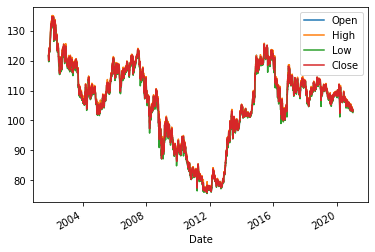

In [5]:
df.plot(y=['Open','High','Low','Close'])

# Forecasting

In [6]:
# Importing Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import timedelta
from sklearn.preprocessing import RobustScaler
plt.style.use("bmh")

# Technical Analysis library
import ta

# Neural Network library
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [7]:
## Technical Indicators

# Adding all the indicators
df = ta.add_all_ta_features(df, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)

/opt/conda/lib/python3.8/site-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/opt/conda/lib/python3.8/site-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


In [8]:
df.tail()

,Open,High,Low,Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_mfi,...,momentum_wr,momentum_ao,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-29,103.779,103.830,103.430,103.560,1,267.104453,20,-0.034205,-0.015823,42.862489,...,-58.959538,-0.435709,103.854323,-0.450836,0.0,0.0,0.0,-0.220640,-0.220884,-14.954422
2020-12-30,103.567,103.600,102.930,103.182,1,266.856692,19,-0.034026,-0.067563,35.700121,...,-76.783217,-0.421362,103.840158,-0.813243,0.0,0.0,0.0,-0.365006,-0.365674,-15.264844
2020-12-31,103.154,103.315,102.960,103.259,1,267.541199,20,0.027903,-0.046911,35.721185,...,-68.610898,-0.467226,103.829379,-0.379153,0.0,0.0,0.0,0.074625,0.074598,-15.201610
2021-01-01,103.248,103.267,103.191,103.191,1,266.541199,19,-0.051180,-0.049924,42.863567,...,-73.829624,-0.486062,103.821509,-0.231074,0.0,0.0,0.0,-0.065854,-0.065876,-15.257453
2021-01-04,103.234,103.262,102.680,103.043,1,266.788622,18,-0.025688,-0.063935,42.887156,...,-70.678514,-0.578897,103.798361,-0.028136,0.0,0.0,0.0,-0.143423,-0.143526,-15.378993


In [9]:
# Dropping everything else besides 'Close' and the Indicators
df.drop(['Open', 'High', 'Low', 'Volume'], axis=1, inplace=True)

# Only using the last 1000 days of data to get a more accurate representation of the current market climate
df = df.tail(1000)



## Scaling

# Scale fitting the close prices separately for inverse_transformations purposes later
close_scaler = RobustScaler()

close_scaler.fit(df[['Close']])

# Normalizing/Scaling the DF
scaler = RobustScaler()

df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

In [10]:
def split_sequence(seq, n_steps_in, n_steps_out):
    """
    Splits the multivariate time sequence
    """
    
    # Creating a list for both variables
    X, y = [], []
    
    for i in range(len(seq)):
        
        # Finding the end of the current sequence
        end = i + n_steps_in
        out_end = end + n_steps_out
        
        # Breaking out of the loop if we have exceeded the dataset's length
        if out_end > len(seq):
            break
        
        # Splitting the sequences into: x = past prices and indicators, y = prices ahead
        seq_x, seq_y = seq[i:end, :], seq[end:out_end, 0]
        
        X.append(seq_x)
        y.append(seq_y)

    return np.array(X), np.array(y)
  
def visualize_training_results(results):
    """
    Plots the loss and accuracy for the training and testing data
    """
    history = results.history
    plt.figure(figsize=(16,5))
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure(figsize=(16,5))
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()
    
    
def layer_maker(n_layers, n_nodes, activation, drop=None, d_rate=.5):
    """
    Creates a specified number of hidden layers for an RNN
    Optional: Adds regularization option - the dropout layer to prevent potential overfitting (if necessary)
    """
    
    # Creating the specified number of hidden layers with the specified number of nodes
    for x in range(1,n_layers+1):
        model.add(LSTM(n_nodes, activation=activation, return_sequences=True))

        # Adds a Dropout layer after every Nth hidden layer (the 'drop' variable)
        try:
            if x % drop == 0:
                model.add(Dropout(d_rate))
        except:
            pass

          
def validater(n_per_in, n_per_out):
    """
    Runs a 'For' loop to iterate through the length of the DF and create predicted values for every stated interval
    Returns a DF containing the predicted values for the model with the corresponding index values based on a business day frequency
    """
    
    # Creating an empty DF to store the predictions
    predictions = pd.DataFrame(index=df.index, columns=[df.columns[0]])

    for i in range(n_per_in, len(df)-n_per_in, n_per_out):
        # Creating rolling intervals to predict off of
        x = df[-i - n_per_in:-i]

        # Predicting using rolling intervals
        yhat = model.predict(np.array(x).reshape(1, n_per_in, n_features))

        # Transforming values back to their normal prices
        yhat = close_scaler.inverse_transform(yhat)[0]

        # DF to store the values and append later, frequency uses business days
        pred_df = pd.DataFrame(yhat, 
                               index=pd.date_range(start=x.index[-1], 
                                                   periods=len(yhat), 
                                                   freq="B"),
                               columns=[x.columns[0]])

        # Updating the predictions DF
        predictions.update(pred_df)
        
    return predictions


def val_rmse(df1, df2):
    """
    Calculates the root mean square error between the two Dataframes
    """
    df = df1.copy()
    
    # Adding a new column with the closing prices from the second DF
    df['close2'] = df2.Close
    
    # Dropping the NaN values
    df.dropna(inplace=True)
    
    # Adding another column containing the difference between the two DFs' closing prices
    df['diff'] = df.Close - df.close2
    
    # Squaring the difference and getting the mean
    rms = (df[['diff']]**2).mean()
    
    # Returning the sqaure root of the root mean square
    return float(np.sqrt(rms))
  

In [11]:
# How many periods looking back to learn
n_per_in  = 90
# How many periods to predict
n_per_out = 30
# Features 
n_features = df.shape[1]
# Splitting the data into appropriate sequences
X, y = split_sequence(df.to_numpy(), n_per_in, n_per_out)

In [16]:
## Creating the NN

# Instatiating the model
model = Sequential()

# Activation
activ = "tanh"

# Input layer
model.add(LSTM(90, 
               activation=activ, 
               return_sequences=True, 
               input_shape=(n_per_in, n_features)))

# Hidden layers
layer_maker(n_layers=1, 
            n_nodes=30, 
            activation=activ)

# Final Hidden layer
model.add(LSTM(60, activation=activ))

# Output layer
model.add(Dense(n_per_out))

# Model summary
model.summary()

# Compiling the data with selected specifications
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

## Fitting and Training
res = model.fit(X, y, epochs=50, batch_size=128, validation_split=0.1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 90, 90)            63000     
_________________________________________________________________
lstm_5 (LSTM)                (None, 90, 30)            14520     
_________________________________________________________________
lstm_6 (LSTM)                (None, 60)                21840     
_________________________________________________________________
dense_1 (Dense)              (None, 30)                1830      
Total params: 101,190
Trainable params: 101,190
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
7/7 [==============================] - 2s 243ms/step - loss: 0.3012 - accuracy: 0.0328 - val_loss: 1.0207 - val_accuracy: 0.0562
Epoch 2/50
7/7 [==============================] - 1s 129ms/step - loss: 0.2207 - accuracy: 0.0341 - val_lo

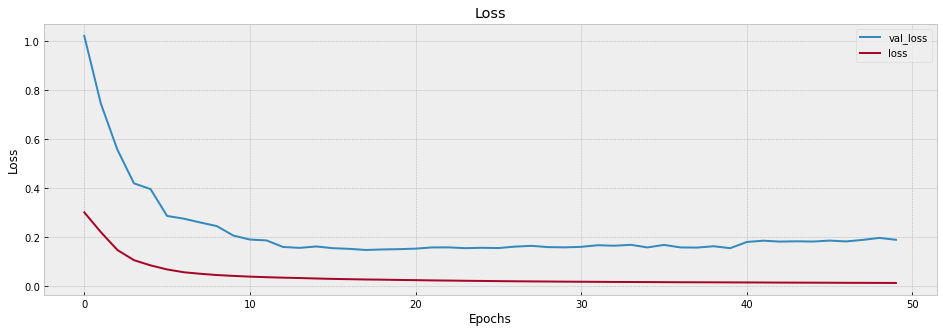

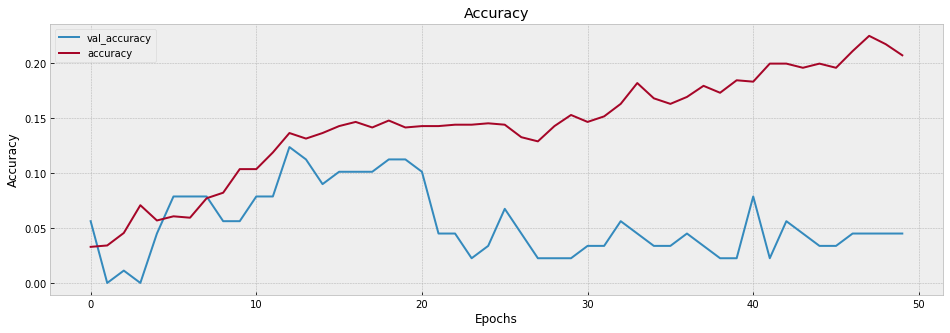

In [17]:
visualize_training_results(res)

RMSE: 0.508632177339194


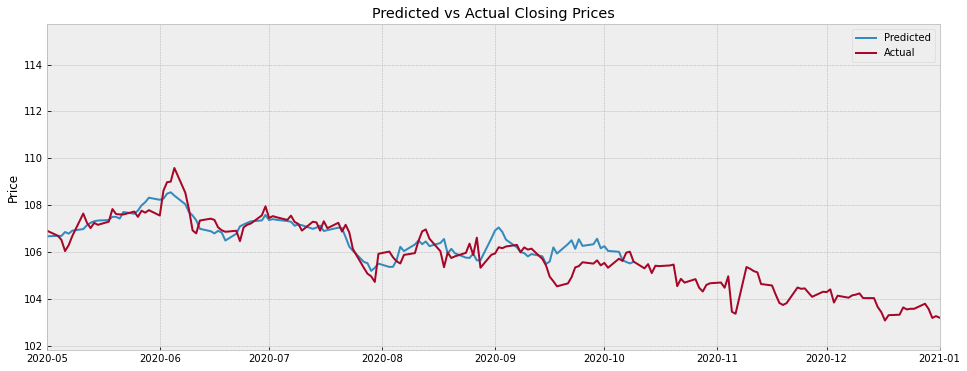

In [29]:
# Transforming the actual values to their original price
actual = pd.DataFrame(close_scaler.inverse_transform(df[["Close"]]), 
                      index=df.index, 
                      columns=[df.columns[0]])

# Getting a DF of the predicted values to validate against
predictions = validater(n_per_in, n_per_out)

# Printing the RMSE
print("RMSE:", val_rmse(actual, predictions))
    
# Plotting
plt.figure(figsize=(16,6))

# Plotting those predictions
plt.plot(predictions, label='Predicted')

# Plotting the actual values
plt.plot(actual, label='Actual')

plt.title(f"Predicted vs Actual Closing Prices")
plt.ylabel("Price")
plt.legend()
plt.xlim('2020-05', '2021-01')
plt.show()

                 Close
2021-01-05  106.857506
2021-01-06  107.005096
2021-01-07  107.177818
2021-01-08  106.994461
2021-01-11  106.812492
2021-01-12  106.638161
2021-01-13  105.955521
2021-01-14  106.776154
2021-01-15  106.584152
2021-01-18  107.331116
2021-01-19  107.337265
2021-01-20  107.176407
2021-01-21  107.733772
2021-01-22  107.554657
2021-01-25  107.242493
2021-01-26  107.211723
2021-01-27  108.080154
2021-01-28  106.876350
2021-01-29  106.801064
2021-02-01  106.226852
2021-02-02  106.110031
2021-02-03  105.771591
2021-02-04  105.796974
2021-02-05  105.462273
2021-02-08  105.077347
2021-02-09  105.630196
2021-02-10  105.211426
2021-02-11  105.349480
2021-02-12  105.257454
2021-02-15  105.159515


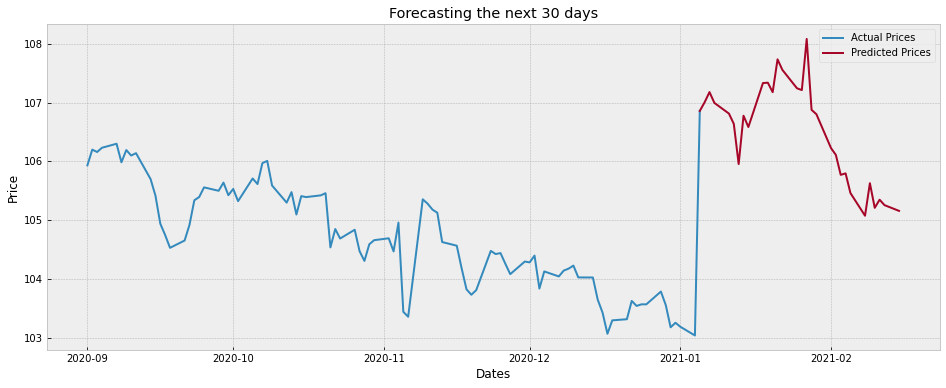

In [19]:
# Predicting off of the most recent days from the original DF
yhat = model.predict(np.array(df.tail(n_per_in)).reshape(1, n_per_in, n_features))

# Transforming the predicted values back to their original format
yhat = close_scaler.inverse_transform(yhat)[0]

# Creating a DF of the predicted prices
preds = pd.DataFrame(yhat, 
                     index=pd.date_range(start=df.index[-1]+timedelta(days=1), 
                                         periods=len(yhat), 
                                         freq="B"), 
                     columns=[df.columns[0]])

# Number of periods back to plot the actual values
pers = n_per_in

# Transforming the actual values to their original price
actual = pd.DataFrame(close_scaler.inverse_transform(df[["Close"]].tail(pers)), 
                      index=df.Close.tail(pers).index, 
                      columns=[df.columns[0]]).append(preds.head(1))

# Printing the predicted prices
print(preds)

# Plotting
plt.figure(figsize=(16,6))
plt.plot(actual, label="Actual Prices")
plt.plot(preds, label="Predicted Prices")
plt.ylabel("Price")
plt.xlabel("Dates")
plt.title(f"Forecasting the next {len(yhat)} days")
plt.legend()
plt.show()